## Modelos de Volatilidad
Esta ultima seccion revisara los modelos ARCH: Autorregresivos con heterocedasticidad condicional

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from arch import arch_model
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_white, het_arch
from functions.arch_selection import model_selection

import warnings
warnings.simplefilter("ignore")

Hacia adelante, probare con la serie de los futuros del precio del petroleo

In [2]:
dta = yf.Ticker("CL=F").history(period="max")
dta = dta[["Close"]]
dta.rename({"Close": "Oil"}, axis=1, inplace=True)

dta.tail()

,Oil
Date,
2022-11-01,88.370003
2022-11-02,90.000000
2022-11-03,88.169998
2022-11-04,92.610001
2022-11-07,91.870003


In [3]:
retornos = (np.log(dta)-np.log(dta).shift(1))*100
retornos = retornos.dropna()

volatilidad = retornos ** 2


# Definimos las variables
y = retornos
y2 = volatilidad

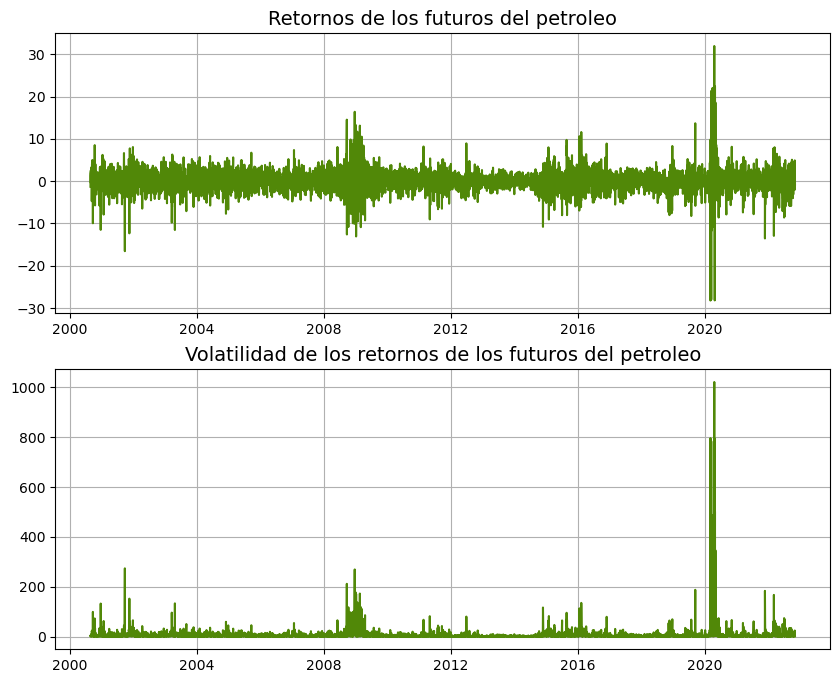

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(y, color = "#518808")
ax[0].set_title("Retornos de los futuros del petroleo", fontsize=14)
ax[0].grid()

ax[1].plot(y2, color = "#518808")
ax[1].set_title("Volatilidad de los retornos de los futuros del petroleo", fontsize=14)
ax[1].grid()

plt.show()

#### Test de heterocadasticidad
Para saber si un modelo cuenta con heterocedasticidad y requiere ser modelado por alguna metodologia ARCH, existen varios test como los siguientes:
* Test de White
* Test de Engle
* Test de Ljung-Box

In [5]:
# Rezago + constante
x = y.shift(1)
X = sm.add_constant(x)


# Eliminando el primer valor
X = X.iloc[1:]
y = y.iloc[1:]
y2 = y2.iloc[1:]


# Estimacion
model = sm.OLS(y, X)
model = model.fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Oil   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.510
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.113
Time:                        17:22:46   Log-Likelihood:                -13342.
No. Observations:                5574   AIC:                         2.669e+04
Df Residuals:                    5572   BIC:                         2.670e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0306      0.036      0.861      0.3

Los tests:

In [6]:
exog = model.model.exog
resids = model.resid


# Tests
white_test = het_white(resids, X)
engle_test = het_arch(resids)
ljungbox_test = sm.stats.acorr_ljungbox(resids, lags=None, return_df=True)

In [7]:
print(f"El test de White da como p-value: {np.round(white_test[1], 3)} y el de Engle: {np.round(engle_test[1], 3)}.\
En ambos casos se rechaza la hipotesis nula de homocedasticidad.")

El test de White da como p-value: 0.0 y el de Engle: 0.0.En ambos casos se rechaza la hipotesis nula de homocedasticidad.


In [8]:
print(f"Para el caso del test de Ljung-Box, la hipotesis nula es de que los erorres estan autocorrelacionados. \
Es decir, que existe autocorrelacion de los retornos/existe efectos ARCH. Los resultados son los siguientes: \n {ljungbox_test}\n\
Se encuentra que no se puede rechazar que los errores esten correlacionados hasta el 7mo rezago.")

Para el caso del test de Ljung-Box, la hipotesis nula es de que los erorres estan autocorrelacionados. Es decir, que existe autocorrelacion de los retornos/existe efectos ARCH. Los resultados son los siguientes: 
       lb_stat  lb_pvalue
1    0.001445   0.969672
2    3.889445   0.143027
3    6.320123   0.097033
4    7.599729   0.107391
5    8.309645   0.139976
6    9.908058   0.128578
7   18.731098   0.009073
8   19.209905   0.013776
9   19.210785   0.023459
10  19.248492   0.037218
Se encuentra que no se puede rechazar que los errores esten correlacionados hasta el 7mo rezago.


#### Propiedades de las series financieras
Como ya se adelanto, las series financieras tienen propiedades que se deben cumplir como las siguientes:
##### 1. No autocorrelacion en los retornos

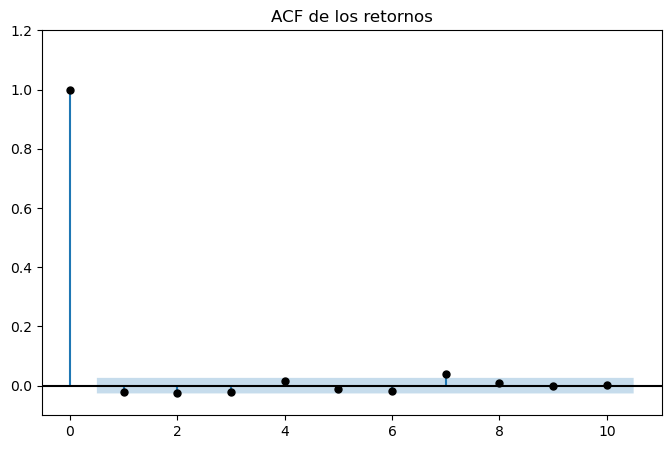

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_acf(y, ax=ax, lags=10, title="ACF de los retornos", color="black")

ax.set_ylim([-0.1, 1.2])

plt.show()

##### 2. Autocorrelacion de los retornos al cuadrado

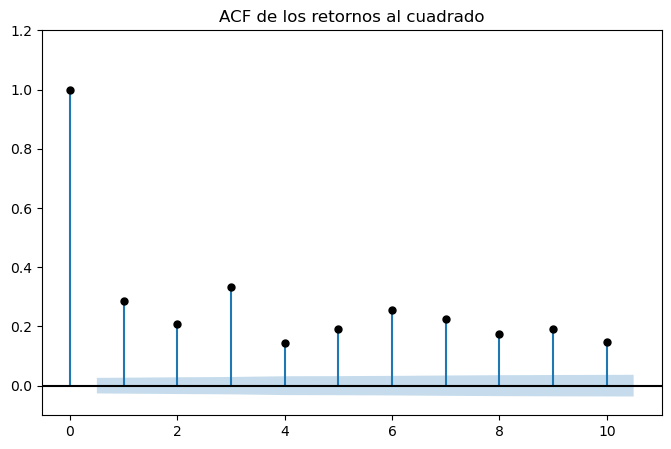

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_acf(y2, ax=ax, lags=10, title="ACF de los retornos al cuadrado", color="black")

ax.set_ylim([-0.1, 1.2])

plt.show()

#### Estimacion por metodologia ARCH
Tras haber encontrado que si existe presencia de efectos ARCH, podemos comenzar a modelar diferentes combinanciones, en el que se encuentre el mejor

In [11]:
arch1 = arch_model(y, p=1, q=0)
arch1 = arch1.fit(disp=False)

print(arch1.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                    Oil   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -12913.0
Distribution:                  Normal   AIC:                           25831.9
Method:            Maximum Likelihood   BIC:                           25851.8
                                        No. Observations:                 5574
Date:                Mon, Nov 07 2022   Df Residuals:                     5573
Time:                        17:22:46   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0782  3.794e-02      2.061  3.931e-02 [3.830e-0

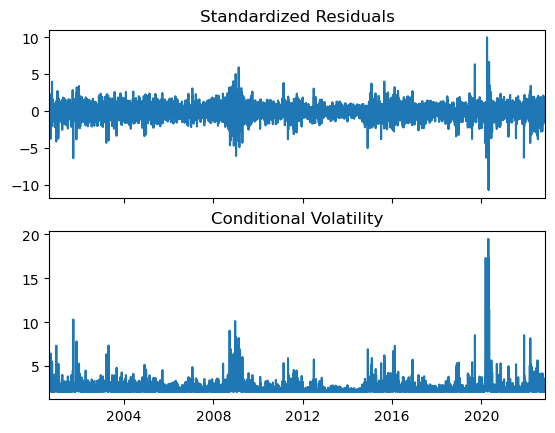

In [12]:
arch1.plot()

plt.show()

De donde se puede acceder a la volatilidad condicional mediante: `arch1.conditional_volatility`

Para poder determinar cual es el mejor modelo, se podria probar con diferentes. Por ello importo una funcion que probara entre varias combinaciones, y da como resultado:

In [13]:
model_selection(y)

El modelo seleccionado es GARCH (2, 2) segun AIC y GARCH (1, 1) segun el BIC.


Siguiendo el modelo seleccionado por el BIC, se planea lo siguiente:

In [14]:
garch = arch_model(y, p=1, q=1)
garch = garch.fit(disp=False)

print(garch.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    Oil   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12312.7
Distribution:                  Normal   AIC:                           24633.4
Method:            Maximum Likelihood   BIC:                           24659.9
                                        No. Observations:                 5574
Date:                Mon, Nov 07 2022   Df Residuals:                     5573
Time:                        17:22:47   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0682  2.703e-02      2.524  1.162e-02 [1.524e-0

Lo resaltante en este modelo es mostrar que su distrubucion no es como de una normal, sino se parece mas a una t-student, por lo que tiene colas pesadas. En ese sentido, es necesario considerar un modelo GARCH asimetrico

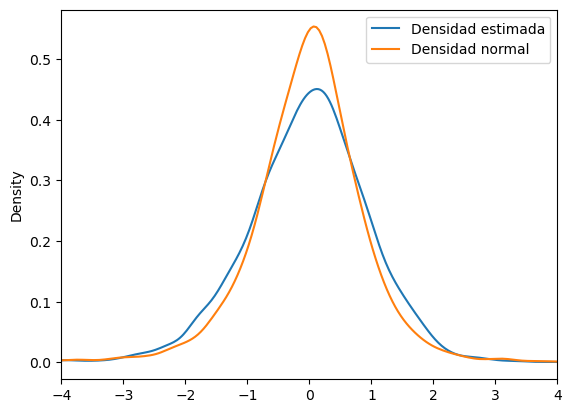

In [15]:
std_resid = garch.resid / garch.conditional_volatility
unit_var_resid = garch.resid / garch.resid.std()


df = pd.concat([std_resid, unit_var_resid], 1)

df.columns = ["Densidad estimada", "Densidad normal"]
subplot = df.plot(kind="kde", xlim=(-4, 4))

#### GARCH-Asimetrico
Con el tiempo se ha planteado mas metodologias que permitan mejorar la estimacion de un modelo de volatilidad. Con un GARCH asimetrico se puede estimar de manera diferente los escenarios de calma con los de incertidumbre.

##### 1. GJR-GARCH o TARCH
La metodologia _Threshold GARC_ fue introducido por Glosten, Jagannanthan y Runkle (1993). La volatilidad es definida mediante la siguiente forma:
$$\sigma_t^2 = \omega + \alpha u_{t-1}^2 + \beta \sigma_{t-1}^2 + \gamma \alpha u_{t-1}^2 I_{u_{t-1}}$$

donde $I_{u_{t-1}}$ tomara el valor de 1 si $u_{t-1}$ es menor a cero. Por el contrario tomara el valor de cero si $u_{t-1}$ es mayor a cero. Esta separacion de regimenes permite capturar la asimetria de momentos financieros buenos y malos

In [16]:
tarch = arch_model(y, p=1, o=1, q=1)
tarch = tarch.fit(disp="off")

print(tarch.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                    Oil   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -12281.5
Distribution:                  Normal   AIC:                           24572.9
Method:            Maximum Likelihood   BIC:                           24606.0
                                        No. Observations:                 5574
Date:                Mon, Nov 07 2022   Df Residuals:                     5573
Time:                        17:22:48   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0274  2.641e-02      1.039      0.299 

##### 2. EGARCH
La metodologia GARCH exponencial es introducido por Nelson (1991)

In [17]:
egarch = arch_model(y, p=1, q=1, vol="EGARCH")
egarch = egarch.fit(disp=False)

print(egarch.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                    Oil   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -12317.7
Distribution:                  Normal   AIC:                           24643.5
Method:            Maximum Likelihood   BIC:                           24670.0
                                        No. Observations:                 5574
Date:                Mon, Nov 07 2022   Df Residuals:                     5573
Time:                        17:22:48   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0683  2.769e-02      2.465  1.369e-02 [1.399e-0

#### 3. GARCH-t
Ademas del GARCH normal, se puede plantear un GARCH distrubuido por una t-student, la cual es una distribucion con colas pesadas

In [18]:
garch_t = arch_model(y, p=1, q=1, dist="t")
garch_t = garch_t.fit(disp=False)

print(garch_t.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          Oil   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -12177.9
Distribution:      Standardized Student's t   AIC:                           24365.7
Method:                  Maximum Likelihood   BIC:                           24398.8
                                              No. Observations:                 5574
Date:                      Mon, Nov 07 2022   Df Residuals:                     5573
Time:                              17:22:48   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

#### Referencias:
* https://pypi.org/project/arch/
* https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html